In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser

from SignalModule import SignalGenerator, Signal
from SlidingWindowModule import SlidingWindow

In [18]:

# ============================================================
# Persistence diagram utilities (H₁)
# ============================================================

def plot_persistences_dim1_on_ax(diagram: np.ndarray, ax):
    """
    Plot H₁ persistence intervals as horizontal bars.

    Parameters
    ----------
    diagram : np.ndarray
        Persistence diagram with shape (2, n),
        where:
            diagram[0] = births
            diagram[1] = deaths
    ax : matplotlib.axes.Axes
        Axis on which to draw the persistence bars
    """
    # --- Input validation ---
    if diagram.ndim != 2 or diagram.shape[0] != 2:
        raise ValueError("Input array must have shape (2, n)")

    births, deaths = diagram
    persistences = deaths - births

    # --- Handle empty diagram safely ---
    if len(persistences) == 0:
        longest_index = 0
    else:
        longest_index = np.argmax(persistences)

    # --- Vertical positions for bars ---
    y_positions = np.arange(len(births))

    # --- Draw persistence intervals ---
    for i, (birth, death) in enumerate(zip(births, deaths)):
        color = "tab:blue" if i == longest_index else "tab:orange"
        ax.hlines(y_positions[i], birth, death, color=color, linewidth=2)

    # --- Axis formatting ---
    ax.set_title("Persistence Diagram (H₁)")
    ax.set_xlabel("Filtration Value")
    ax.set_yticks([])


def get_persistences_dim1(diagram: np.ndarray):
    """
    Compute summary statistics for H₁ persistences.

    Parameters
    ----------
    diagram : np.ndarray
        Persistence diagram with shape (2, n)

    Returns
    -------
    longest_persistence : float
    average_persistence : float
    median_persistence : float
    """
    # --- Input validation ---
    if diagram.ndim != 2 or diagram.shape[0] != 2:
        raise ValueError("Input array must have shape (2, n)")

    births, deaths = diagram
    persistences = deaths - births

    if len(persistences) == 0:
        return 0.0, 0.0, 0.0

    longest_persistence = np.max(persistences)
    average_persistence = np.mean(persistences)
    median_persistence = np.median(persistences)

    return longest_persistence, average_persistence, median_persistence



In [ ]:
def get_possible_taus(
    start_time: float,
    end_time: float,
    M: int,
    num_candidates: int = 30,
):
    """
    Generate tau values such that:
        0.05 * T <= M * tau <= 0.5 * T

    where T is the total time span of the signal.

    Parameters
    ----------
    start_time : float
        Start time of the signal
    end_time : float
        End time of the signal
    M : int
        Sliding window size
    num_candidates : int
        Number of tau values to generate

    Returns
    -------
    tau_values : np.ndarray
        Array of valid tau values
    """

    # Total duration of the signal
    total_time = end_time - start_time

    if total_time <= 0:
        raise ValueError("end_time must be greater than start_time")

    if M <= 0:
        raise ValueError("M must be positive")

    # Solve inequality for tau
    tau_min = 0.05 * total_time / M
    tau_max = 0.5 * total_time / M

    if tau_min >= tau_max:
        raise ValueError(
            "Invalid tau range. Try increasing signal duration or reducing M."
        )

    tau_values = np.linspace(tau_min, tau_max, num_candidates)

    return tau_values


def optimize_tau_for_longest_persistence(
    signal,
    M: int,
    tau_values: np.ndarray,
    reduction_method: str = "pca",
    downscale_sw_space: bool = False,
    sw_space_dim: int | None = None,
):
    """
    Find the tau value that maximizes the longest H₁ persistence bar.

    Parameters
    ----------
    signal : Signal
        Pre-generated signal object
    M : int
        Sliding window size
    tau_values : np.ndarray
        Array of tau values to test
    reduction_method : str
        Dimensionality reduction method (e.g. 'pca')
    downscale_sw_space : bool
        Whether to downscale sliding window space
    sw_space_dim : int | None
        Target dimension if downscaling

    Returns
    -------
    best_tau : float
        Tau value that maximizes longest persistence
    best_persistence : float
        Corresponding longest persistence value
    tau_to_persistence : dict
        Mapping tau → longest persistence (for analysis / plotting)
    """

    tau_to_persistence = {}
    best_tau = None
    best_persistence = -np.inf
    for tau in tau_values:
        # ----------------------------------------------------
        # Sliding window embedding
        # ----------------------------------------------------
        sliding_window = SlidingWindow(
            signal=signal,
            M=M,
            tau=tau,
        )

        if downscale_sw_space:
            sliding_window.downscale_sp_space(
                sw_space_dim,
                method=reduction_method,
            )

        # ----------------------------------------------------
        # Persistent homology (H₁)
        # ----------------------------------------------------
        distance_matrix = sliding_window.get_distance_matrix()

        persistence_diagram = ripser(
            distance_matrix,
            maxdim=1,
            distance_matrix=True,
        )["dgms"][1].T

        # ----------------------------------------------------
        # Extract longest persistence
        # ----------------------------------------------------
        longest_persistence, _, _ = get_persistences_dim1(
            persistence_diagram
        )

        tau_to_persistence[tau] = longest_persistence

        # ----------------------------------------------------
        # Update optimum
        # ----------------------------------------------------
        if longest_persistence > best_persistence:
            best_persistence = longest_persistence
            best_tau = tau

    return best_tau


In [ ]:

# ============================================================
# Main experiment pipeline
# ============================================================

def main(
    function_name: str = "sin",
    function=lambda x: np.sin(x),
    start_time: float = 0.0,
    end_time: float = 20.0,
    step: float = 0.05,
    noise: float = 0.11,
    M: int = 20,
    tau: float = 0.0031,
    reduction_method: str = "pca",
    downscale_signal: bool = False,
    signal_num_points: int | None = None,
    downscale_sw_space: bool = False,
    sw_space_dim: int | None = None,
    optimize_tau: bool = False,
):
    """
    Full pipeline:
    Signal → Sliding Window Embedding → Distance Matrix → Persistent Homology

    Parameters are intentionally explicit for experimentation.
    """

    # --------------------------------------------------------
    # Sanity checks
    # --------------------------------------------------------
    if downscale_signal and signal_num_points is None:
        raise ValueError(
            "signal_num_points must be specified if downscale_signal=True"
        )

    if downscale_sw_space and sw_space_dim is None:
        raise ValueError(
            "sw_space_dim must be specified if downscale_sw_space=True"
        )

    # --------------------------------------------------------
    # Signal generation
    # --------------------------------------------------------
    signal = SignalGenerator(
        start=start_time,
        end=end_time,
        step=step,
        function=function,
        noise=noise,
    ).generate()

    # Optional signal downsampling / normalization
    if downscale_signal:
        signal.normalize(number_of_points=signal_num_points)

    if optimize_tau:
        new_start_time = signal.get_times()[0]
        new_end_time = signal.get_times()[-1]
        possible_taus = get_possible_taus(new_start_time, new_end_time, M, num_candidates=10)
        tau = optimize_tau_for_longest_persistence(
            signal=signal,
            M=M,
            tau_values=possible_taus,
            reduction_method=reduction_method,
            downscale_sw_space=downscale_sw_space,
            sw_space_dim=sw_space_dim,
        )

    # --------------------------------------------------------
    # Sliding window embedding
    # --------------------------------------------------------
    sliding_window = SlidingWindow(
        signal=signal,
        M=M,
        tau=tau,
    )

    # Optional dimensionality reduction of SW space
    if downscale_sw_space:
        sliding_window.downscale_sp_space(sw_space_dim, method=reduction_method)

    # --------------------------------------------------------
    # Persistent homology computation (H₁)
    # --------------------------------------------------------
    distance_matrix = sliding_window.get_distance_matrix()

    persistence_diagram = ripser(
        distance_matrix,
        maxdim=1,
        distance_matrix=True,
    )["dgms"][1].T  # Shape → (2, n)

    # --------------------------------------------------------
    # Visualization layout
    # --------------------------------------------------------
    fig = plt.figure(figsize=(18, 12))
    grid = fig.add_gridspec(2, 2)

    ax_signal = fig.add_subplot(grid[0, :])
    ax_embedding = fig.add_subplot(grid[1, 0])
    ax_persistence = fig.add_subplot(grid[1, 1])

    # --------------------------------------------------------
    # Plot components
    # --------------------------------------------------------
    signal.plot_on_ax(
        ax_signal,
        title=f"{function_name}(t) with noise = {noise}",
    )

    sliding_window.plot_on_ax(
        ax_embedding,
        d=2,
        method=reduction_method,
    )

    plot_persistences_dim1_on_ax(
        persistence_diagram,
        ax_persistence,
    )

    # --------------------------------------------------------
    # Persistence statistics
    # --------------------------------------------------------
    longest_p, average_p, median_p = get_persistences_dim1(
        persistence_diagram
    )

    fig.text(
        0.5,
        -0.05,
        (
            f"Longest persistence: {longest_p:.4f}\n"
            f"Average persistence: {average_p:.4f}\n"
            f"Median persistence: {median_p:.4f}"
        ),
        ha="center",
        fontsize=14,
        fontweight="bold",
    )

    # --------------------------------------------------------
    # Super title
    # --------------------------------------------------------
    fig.suptitle(
        f"""
Signal → Sliding Window → Persistent Homology

function = {function_name}
time ∈ [{start_time}, {end_time}], step = {step}, noise = {noise}
M = {M}, τ = {tau}, reduction = {reduction_method.upper()}
""",
        fontsize=18,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


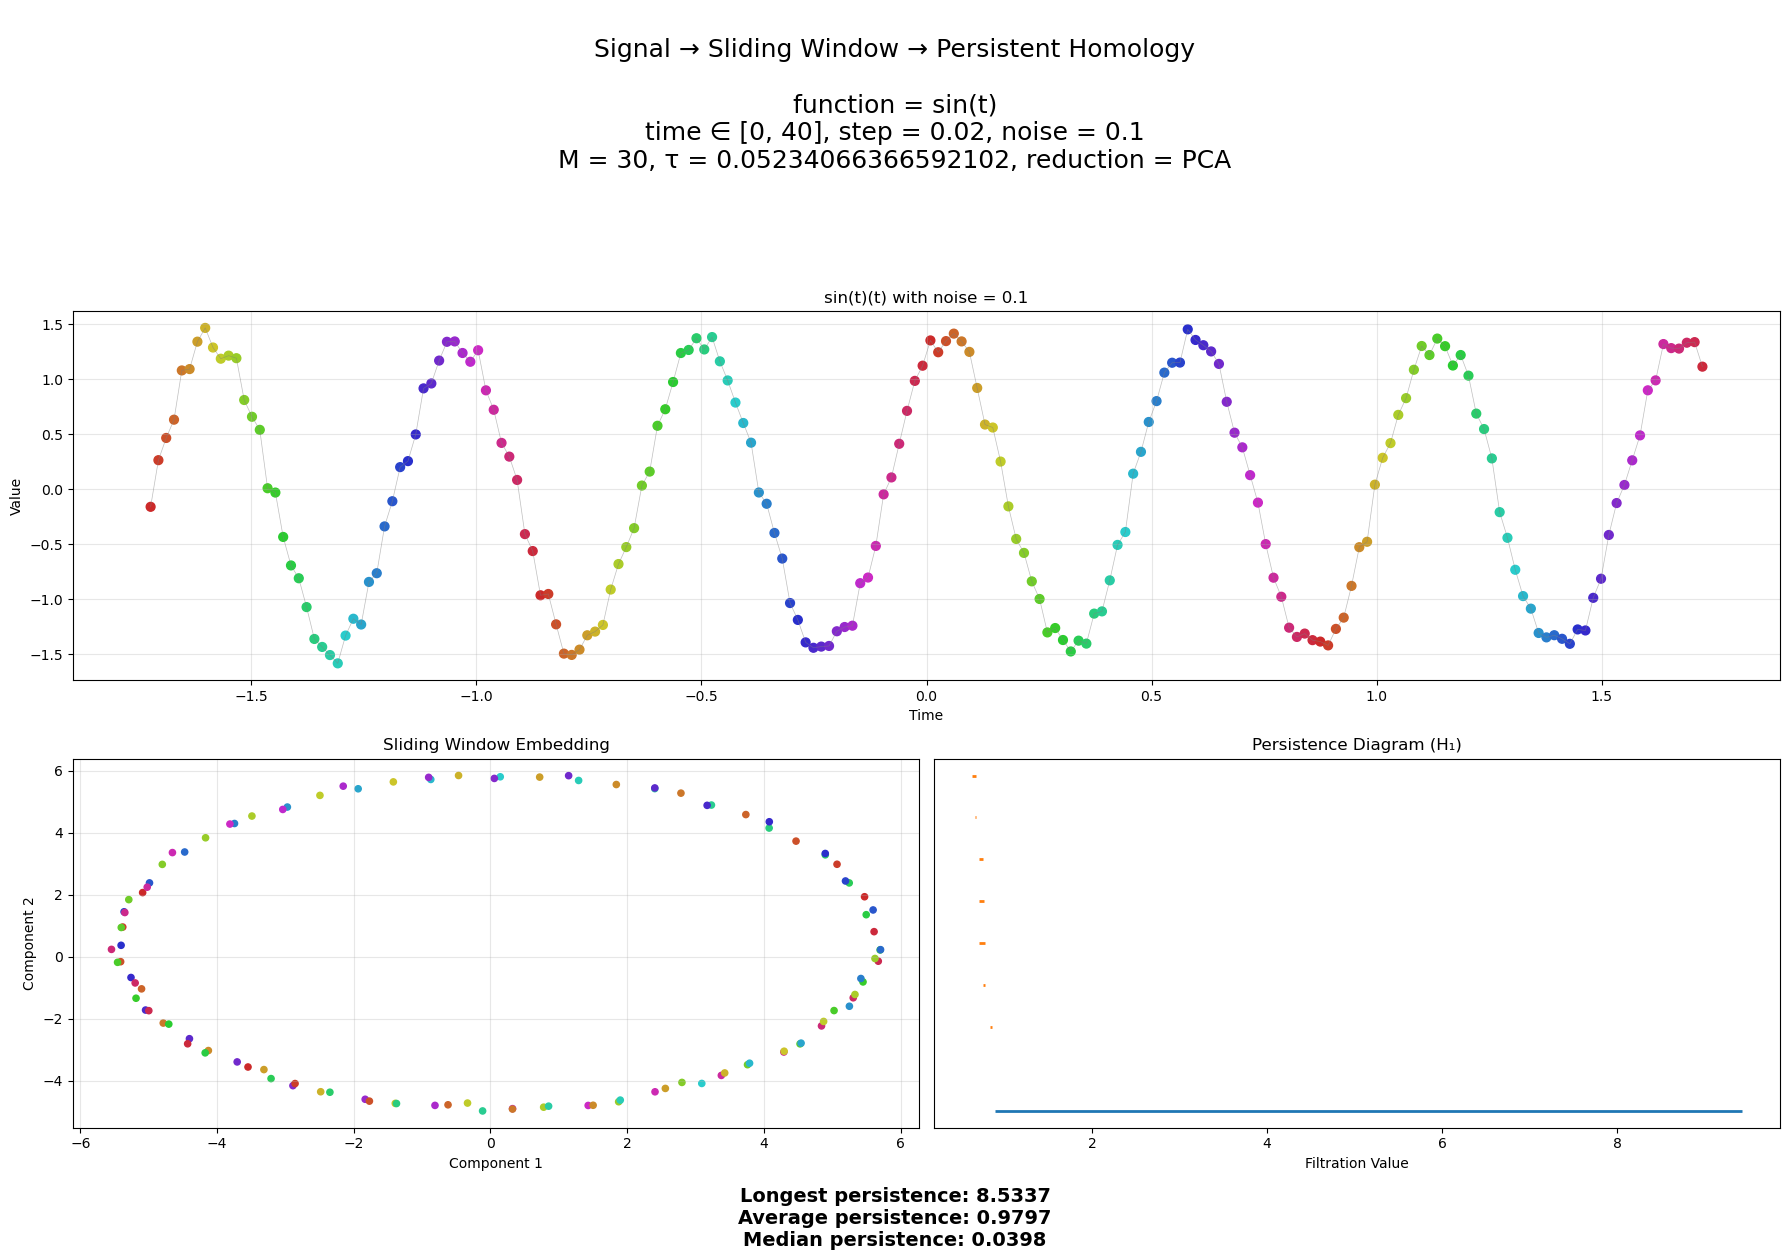

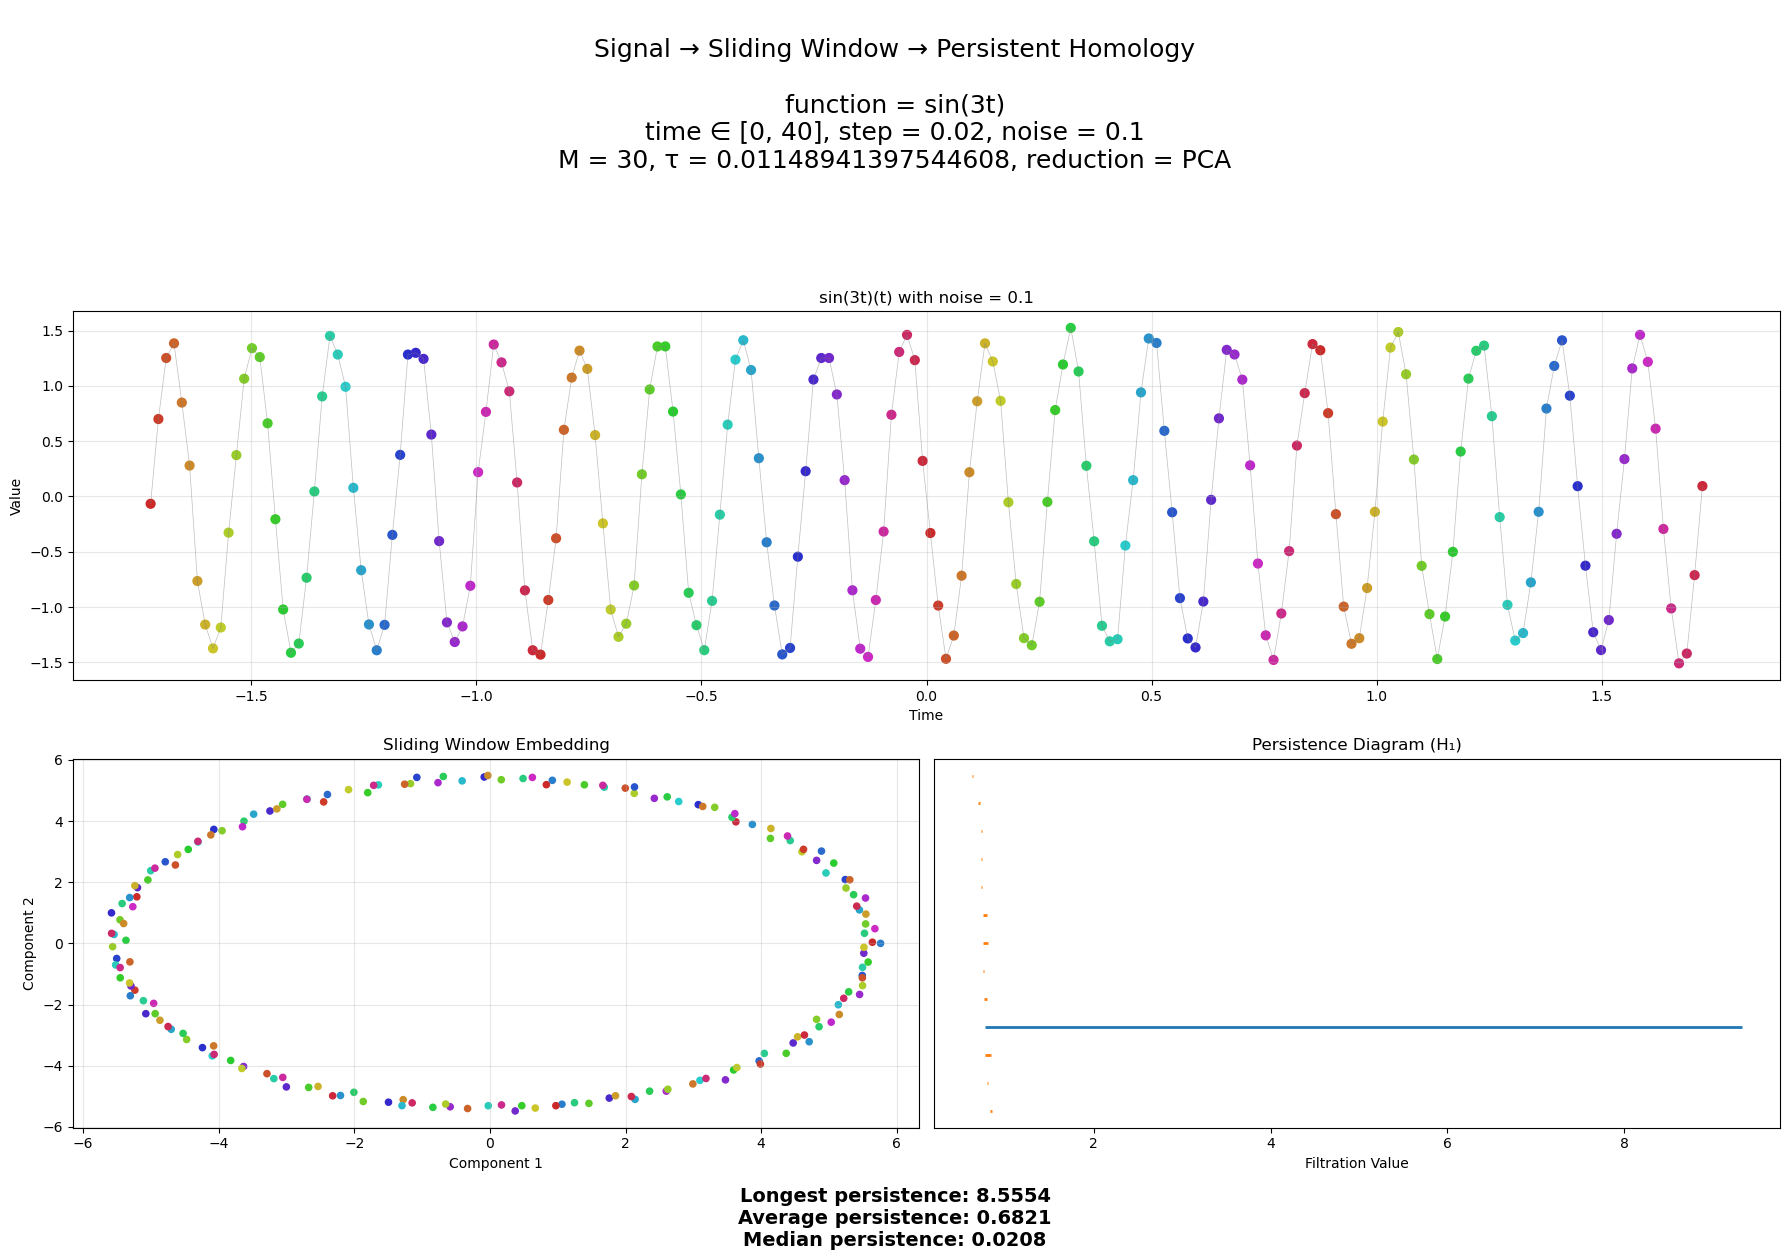

In [26]:
# ============================================================
# 1. Purely periodic signals
# ============================================================

main(
    function_name="sin(t)",
    function=lambda x: np.sin(x),
    start_time=0,
    end_time=40,
    step=0.02,
    noise=0.1,
    M=30,
    tau=0.05,  # initial value (will be optimized)
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=200,
    optimize_tau=True,
)

main(
    function_name="sin(3t)",
    function=lambda x: np.sin(3 * x),
    start_time=0,
    end_time=40,
    step=0.02,
    noise=0.1,
    M=30,
    tau=0.05,
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=200,
    optimize_tau=True,
)


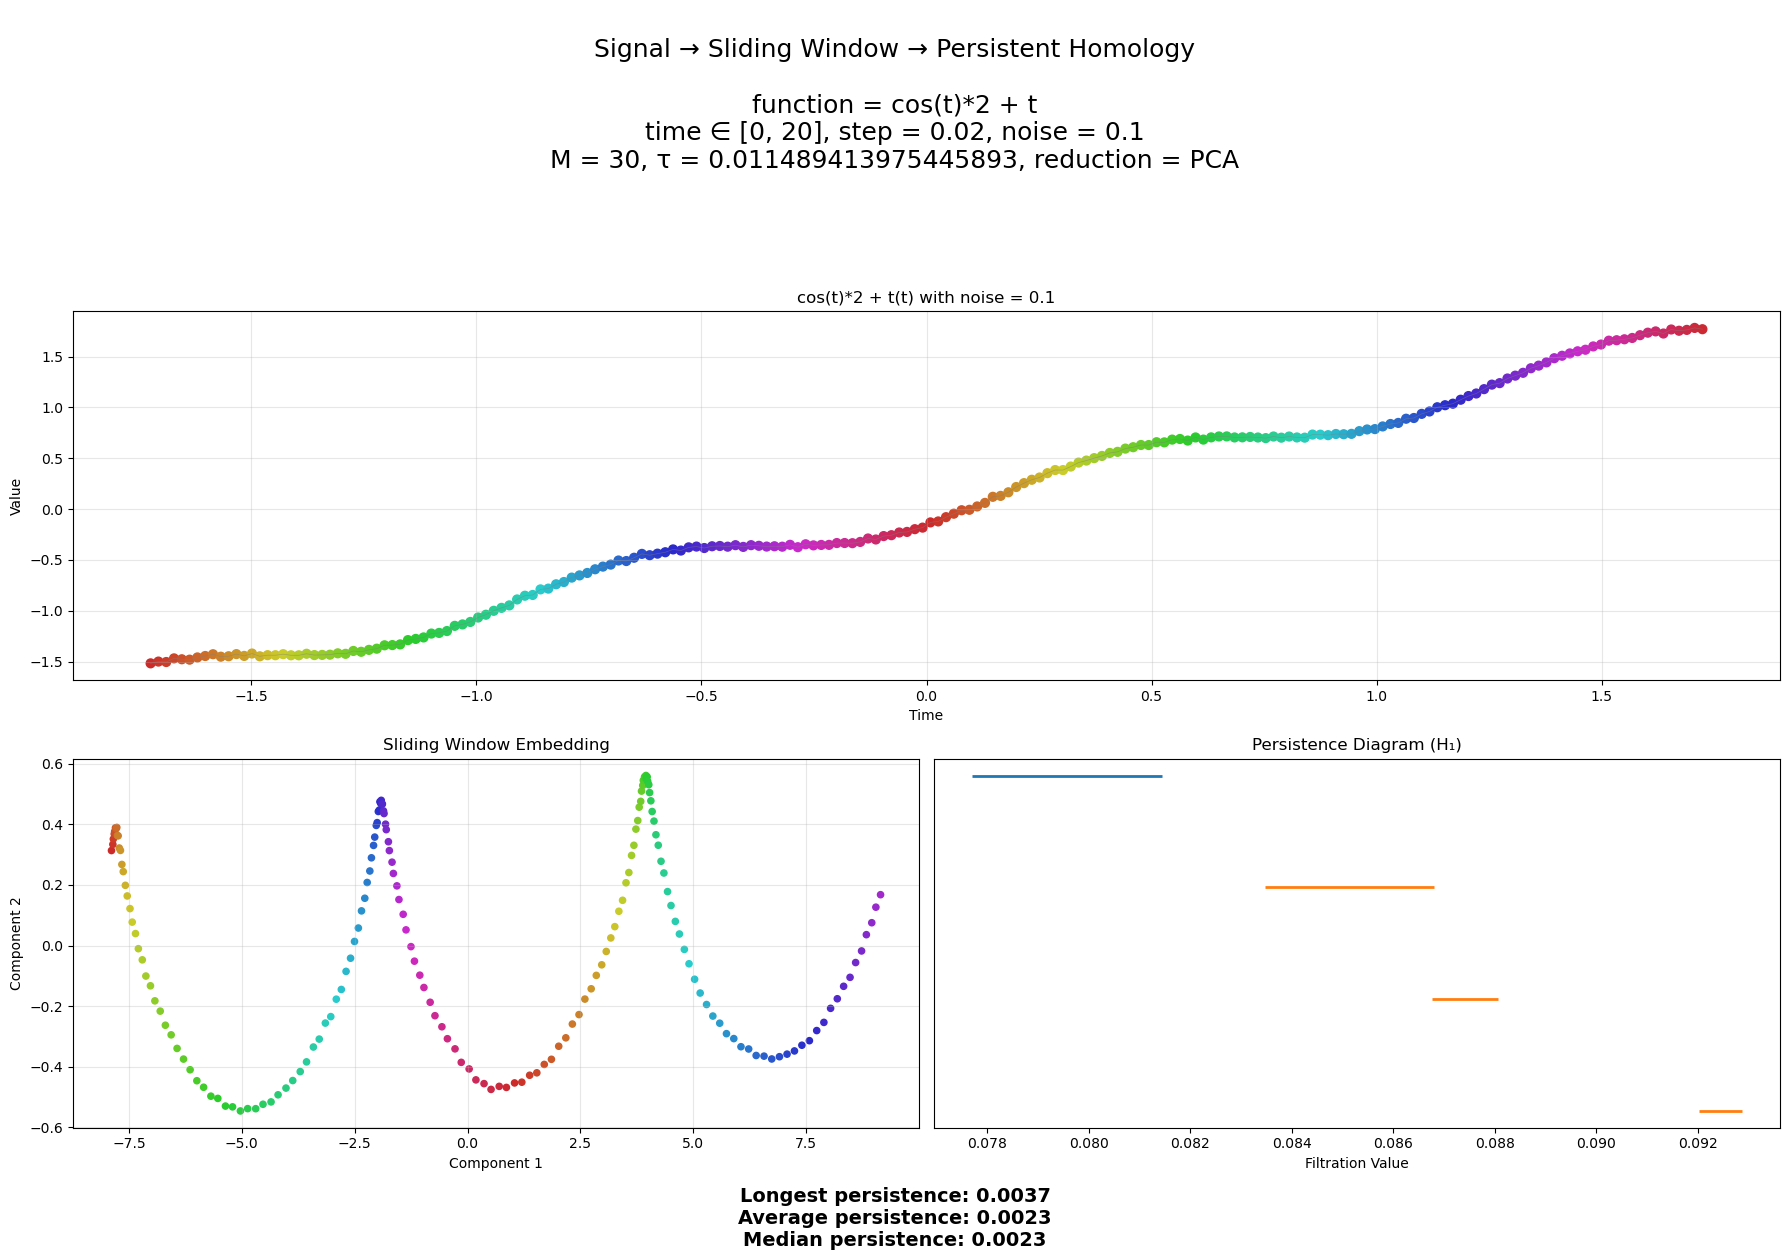

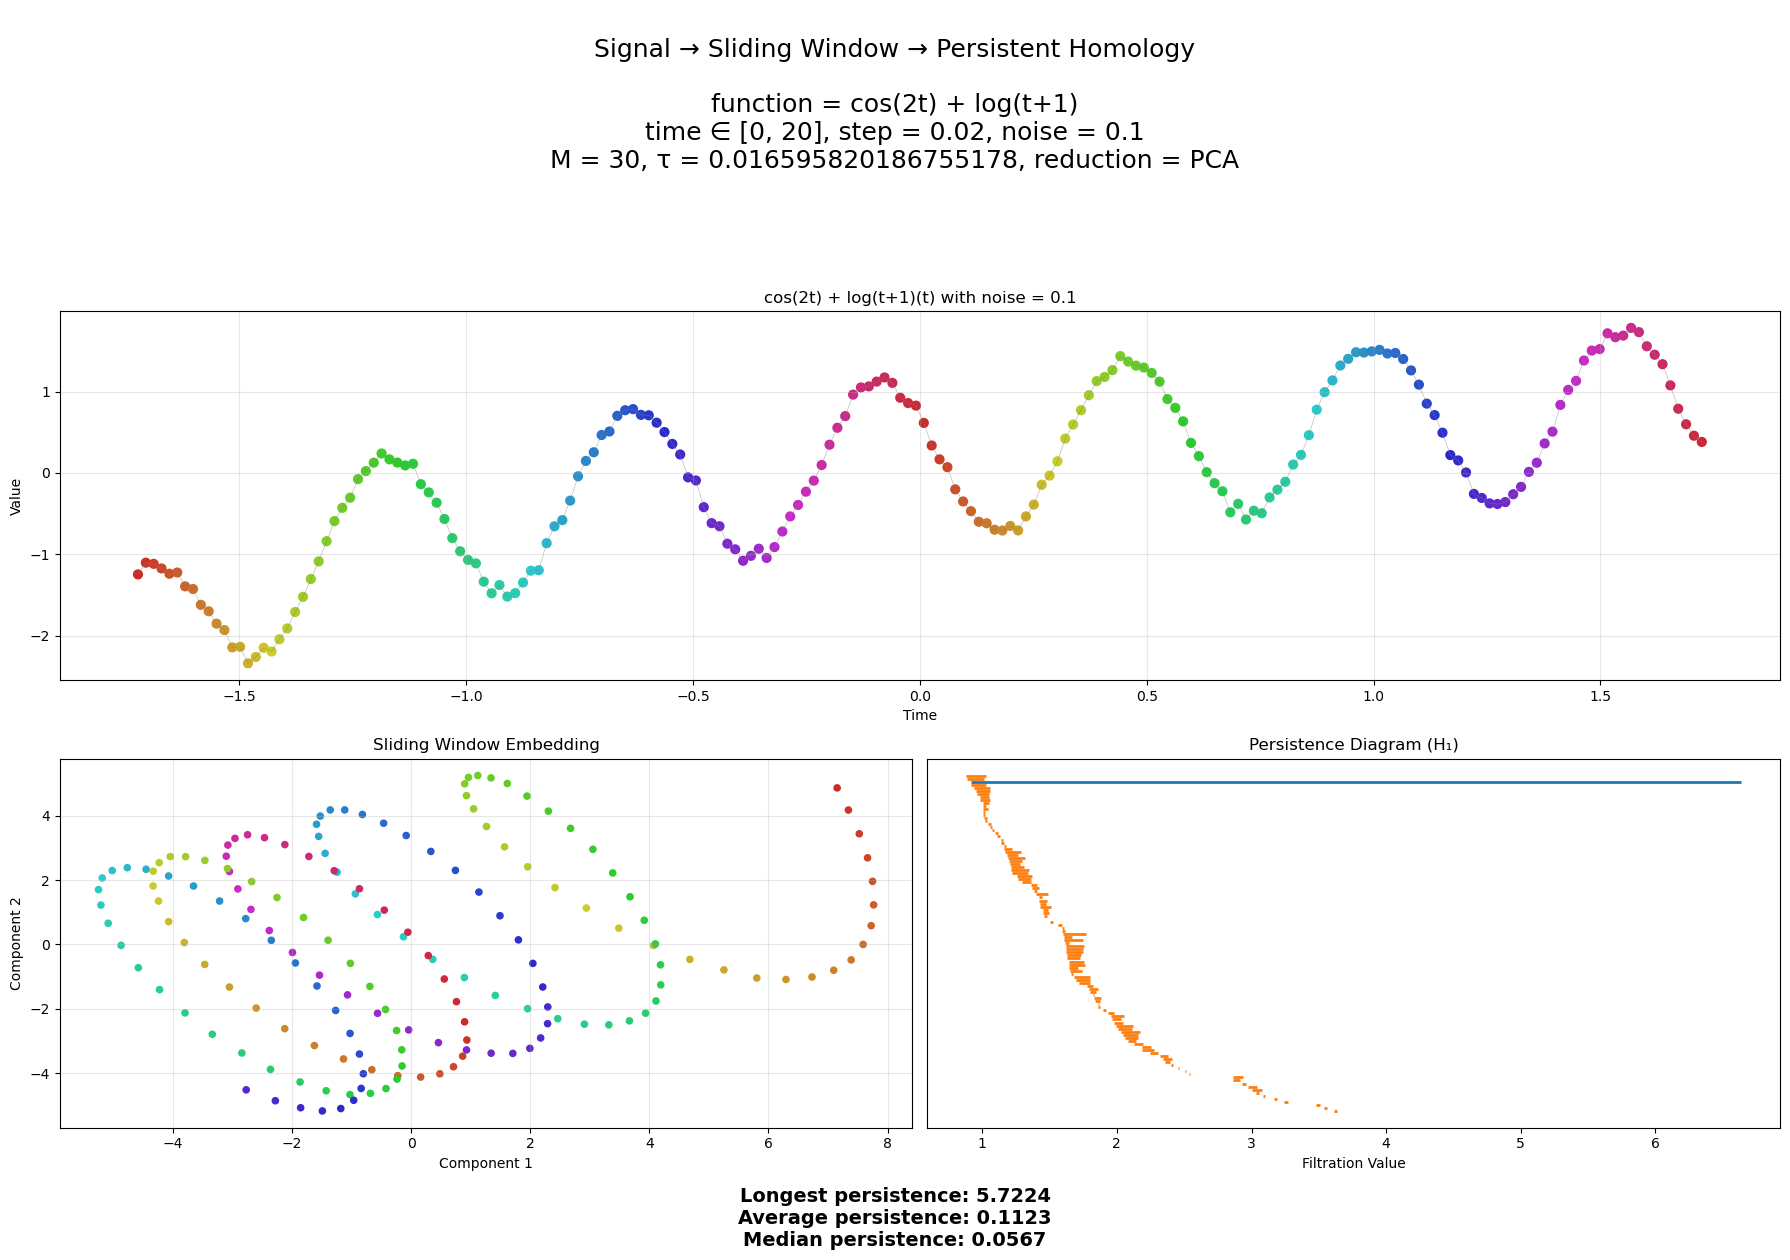

In [29]:
# ============================================================
# 2. Quasi-periodic / drifting periodic signals
# ============================================================

main(
    function_name="cos(t)*2 + t",
    function=lambda x: np.cos(x) + x,
    start_time=0,
    end_time=20,
    step=0.02,
    noise=0.1,
    M=30,
    tau=0.05,
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=200,
    optimize_tau=True,
)

main(
    function_name="cos(2t) + log(t+1)",
    function=lambda x: np.cos(2 * x) + np.log(x + 1),
    start_time=0,
    end_time=20,
    step=0.02,
    noise=0.1,
    M=30,
    tau=0.05,
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=200,
    optimize_tau=True,
)


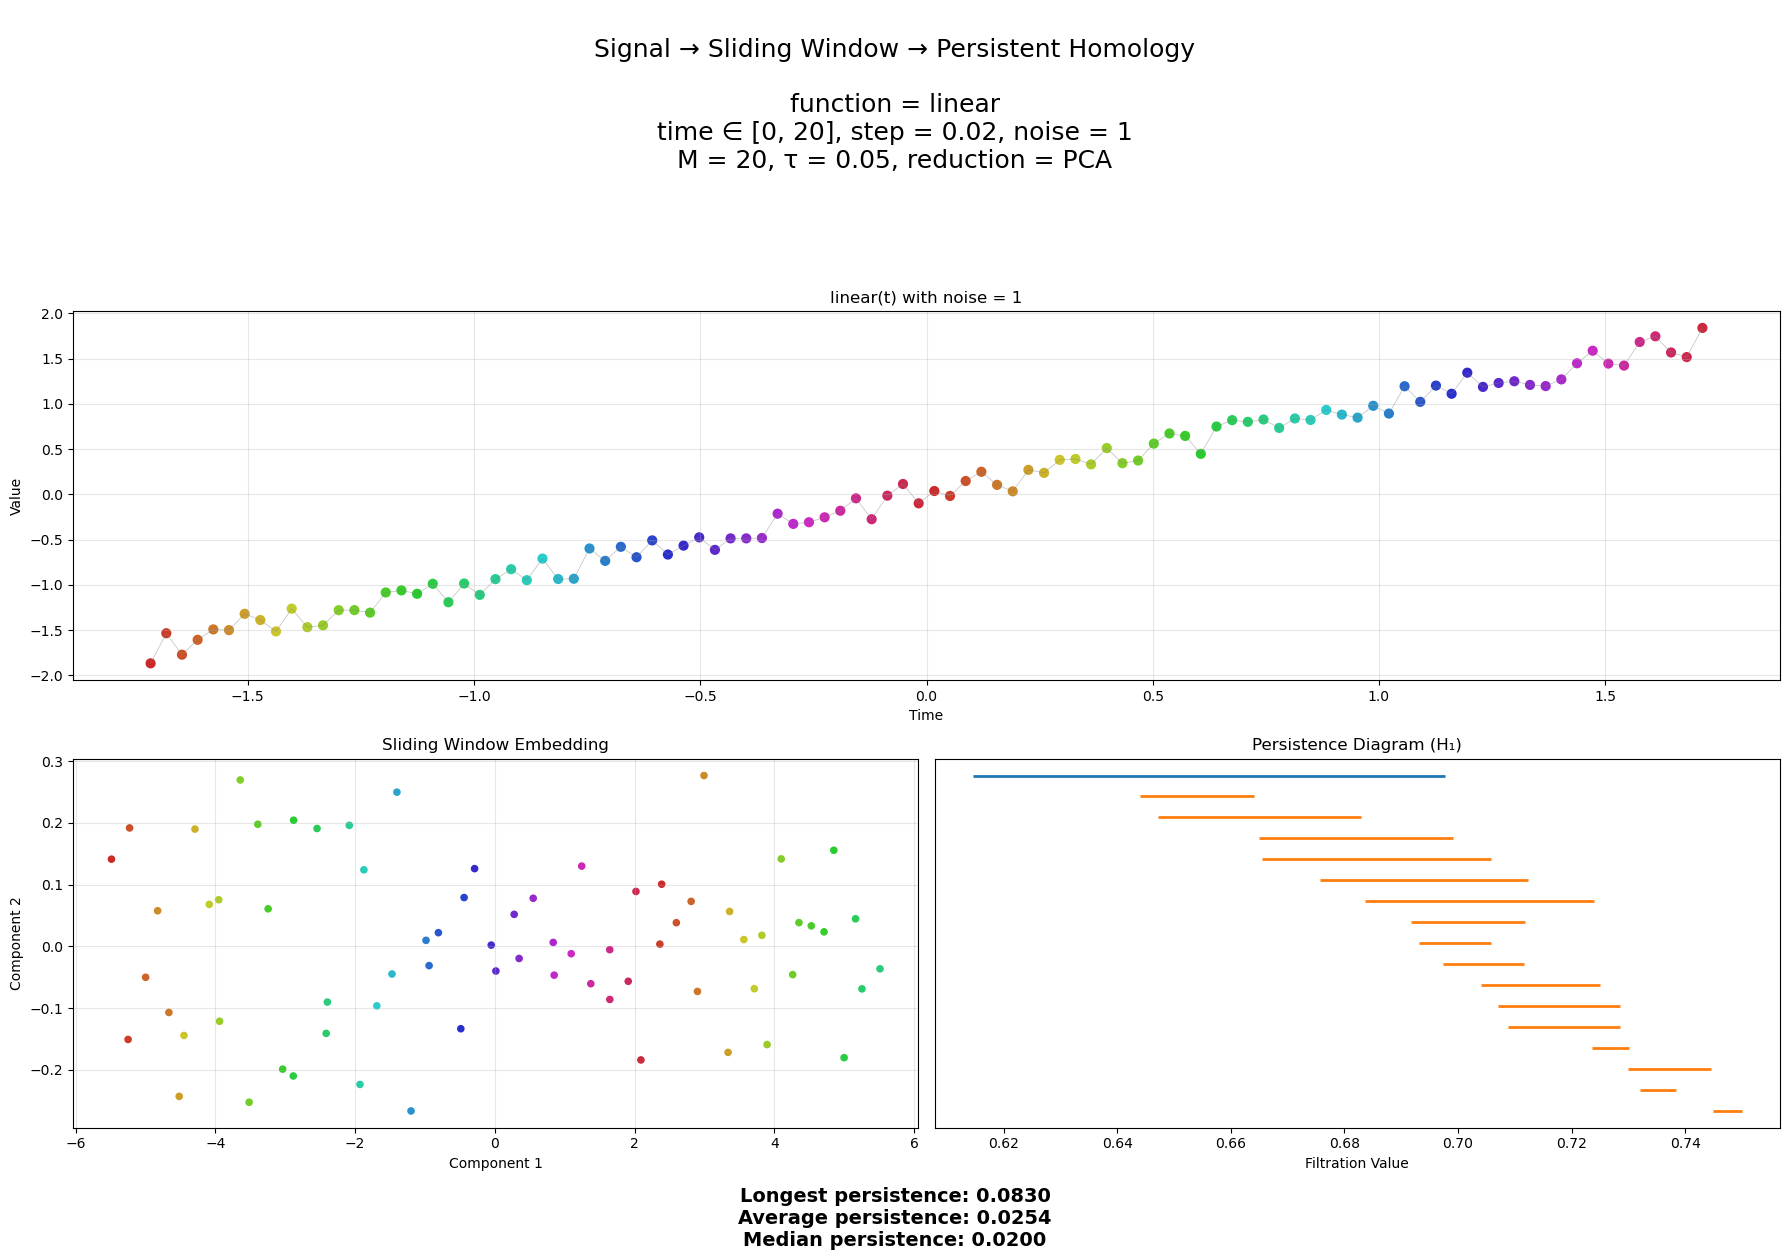

In [21]:
main(
    function_name="linear",
    function=lambda x: x,
    start_time=0,
    end_time=20,
    step=0.02,
    noise=1,
    M=20,
    tau=0.05,
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=100,
    downscale_sw_space=False,
    sw_space_dim=None,
)

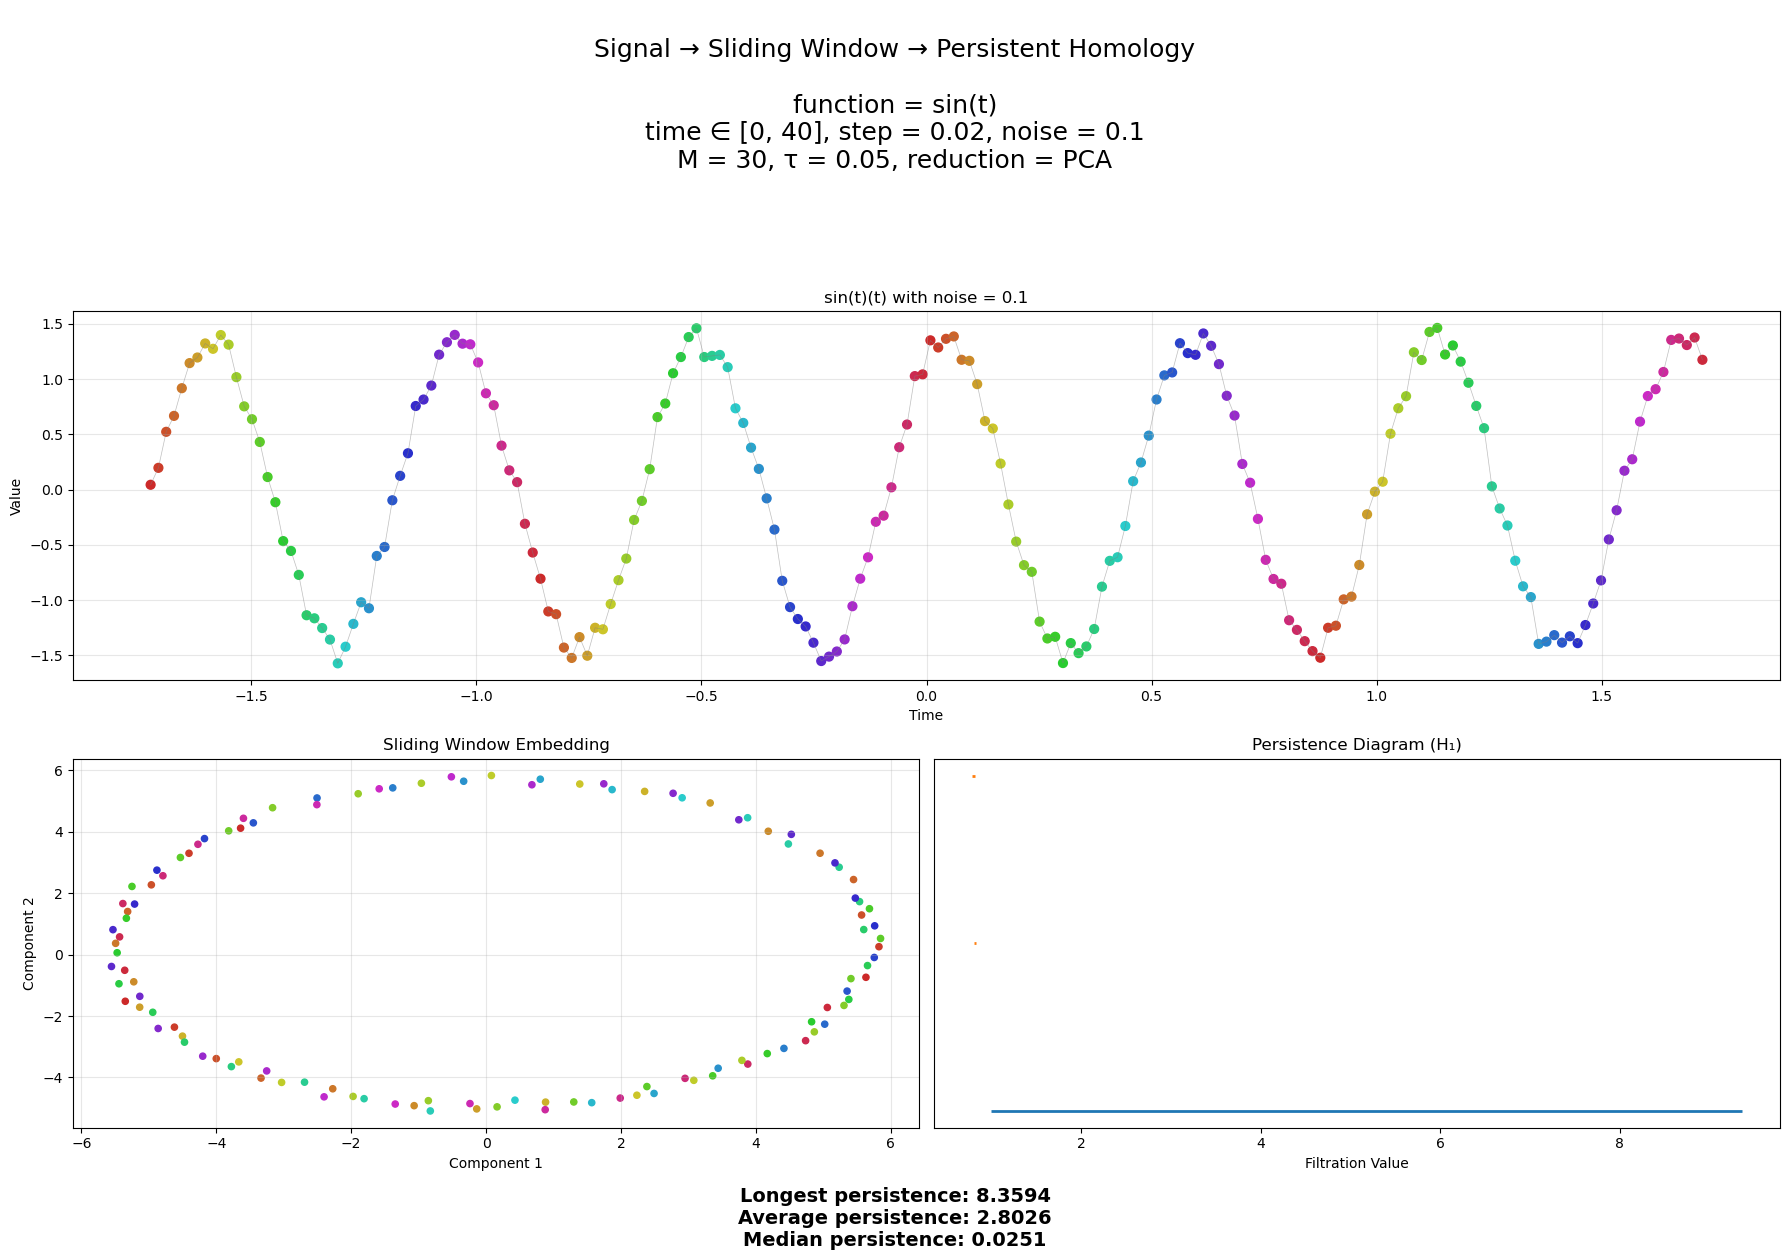

In [22]:
main(
    function_name="sin(t)",
    function=lambda x: np.sin(x),
    start_time=0,
    end_time=40,
    step=0.02,
    noise=0.1,
    M=30,
    tau=0.05,
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=200,
)

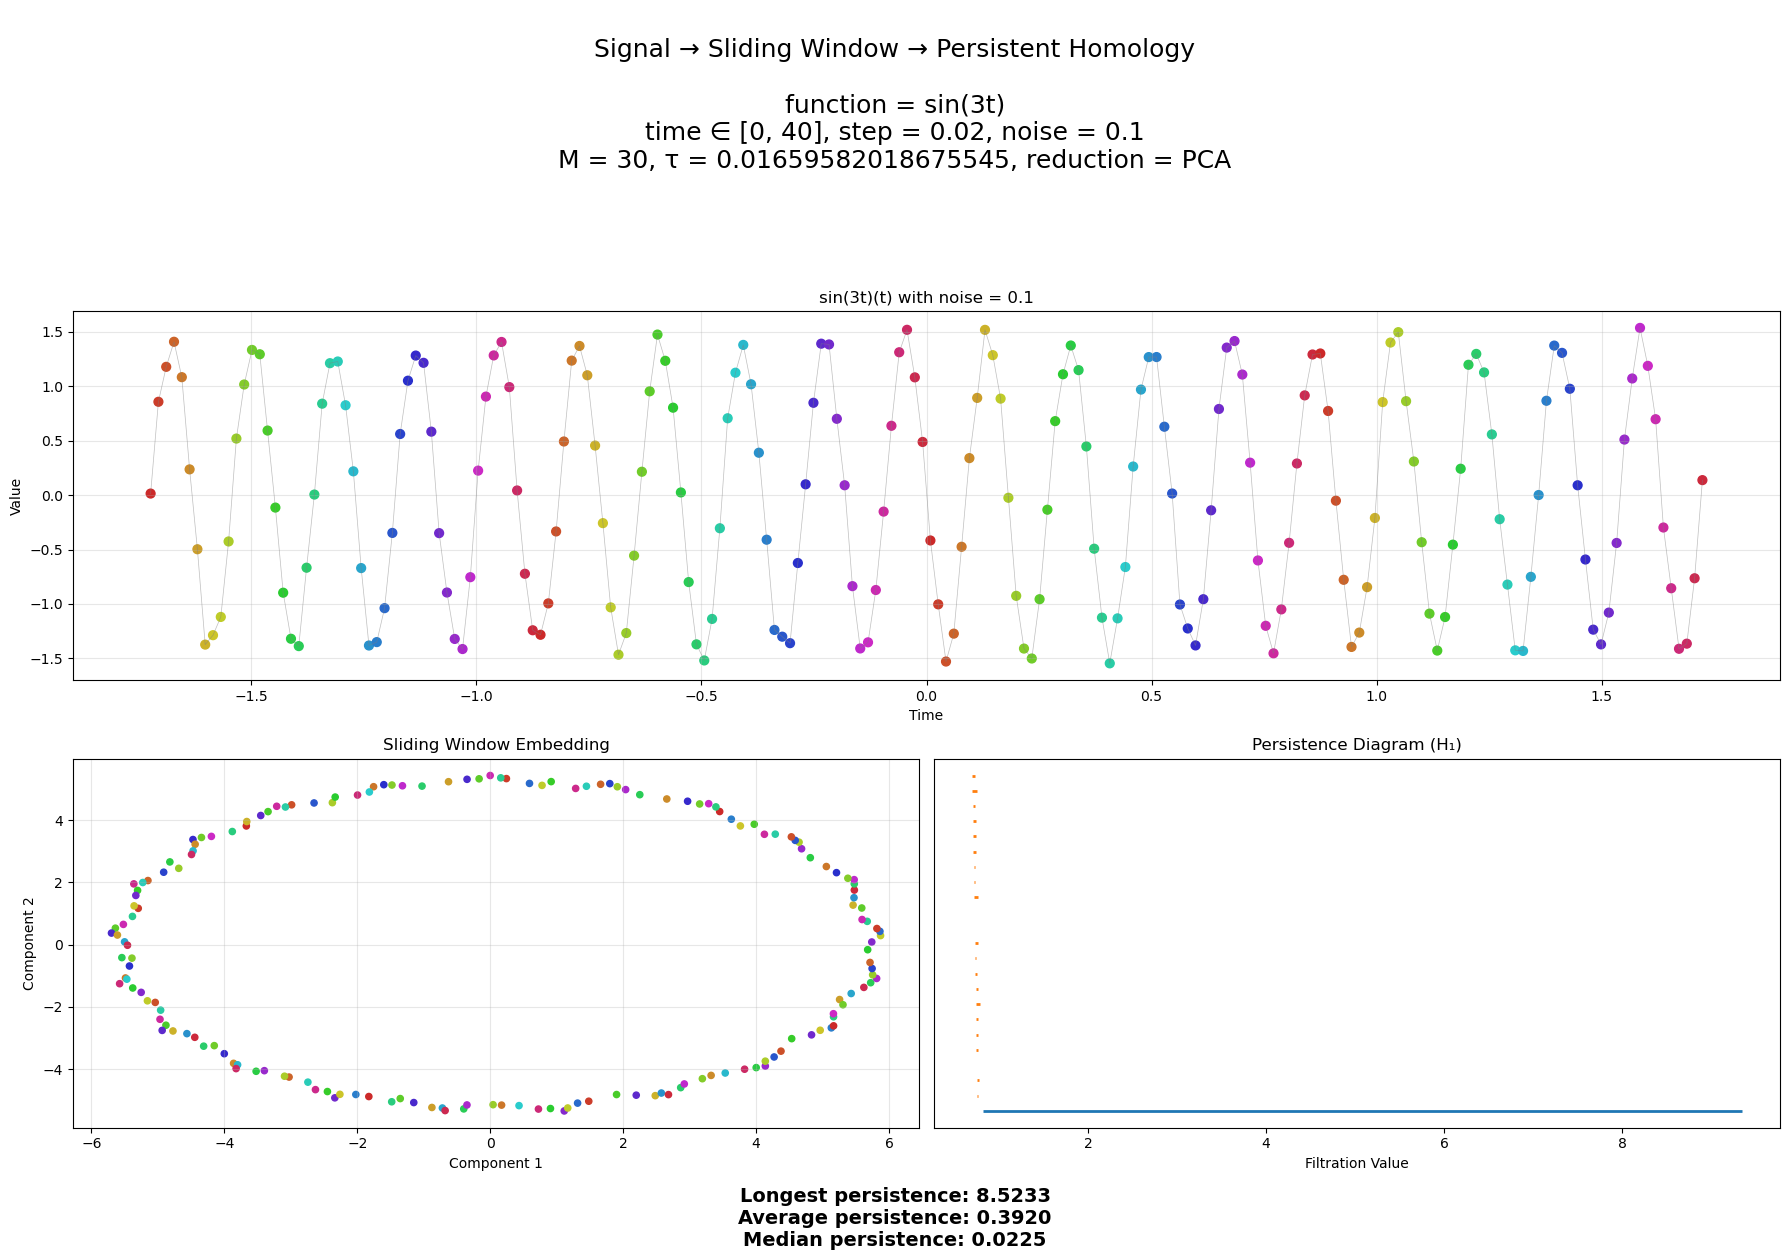

In [23]:
main(
    function_name="sin(3t)",
    function=lambda x: np.sin(3 * x),
    start_time=0,
    end_time=40,
    step=0.02,
    noise=0.1,
    M=30,
    tau=0.05,
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=200,
    optimize_tau=True,
)

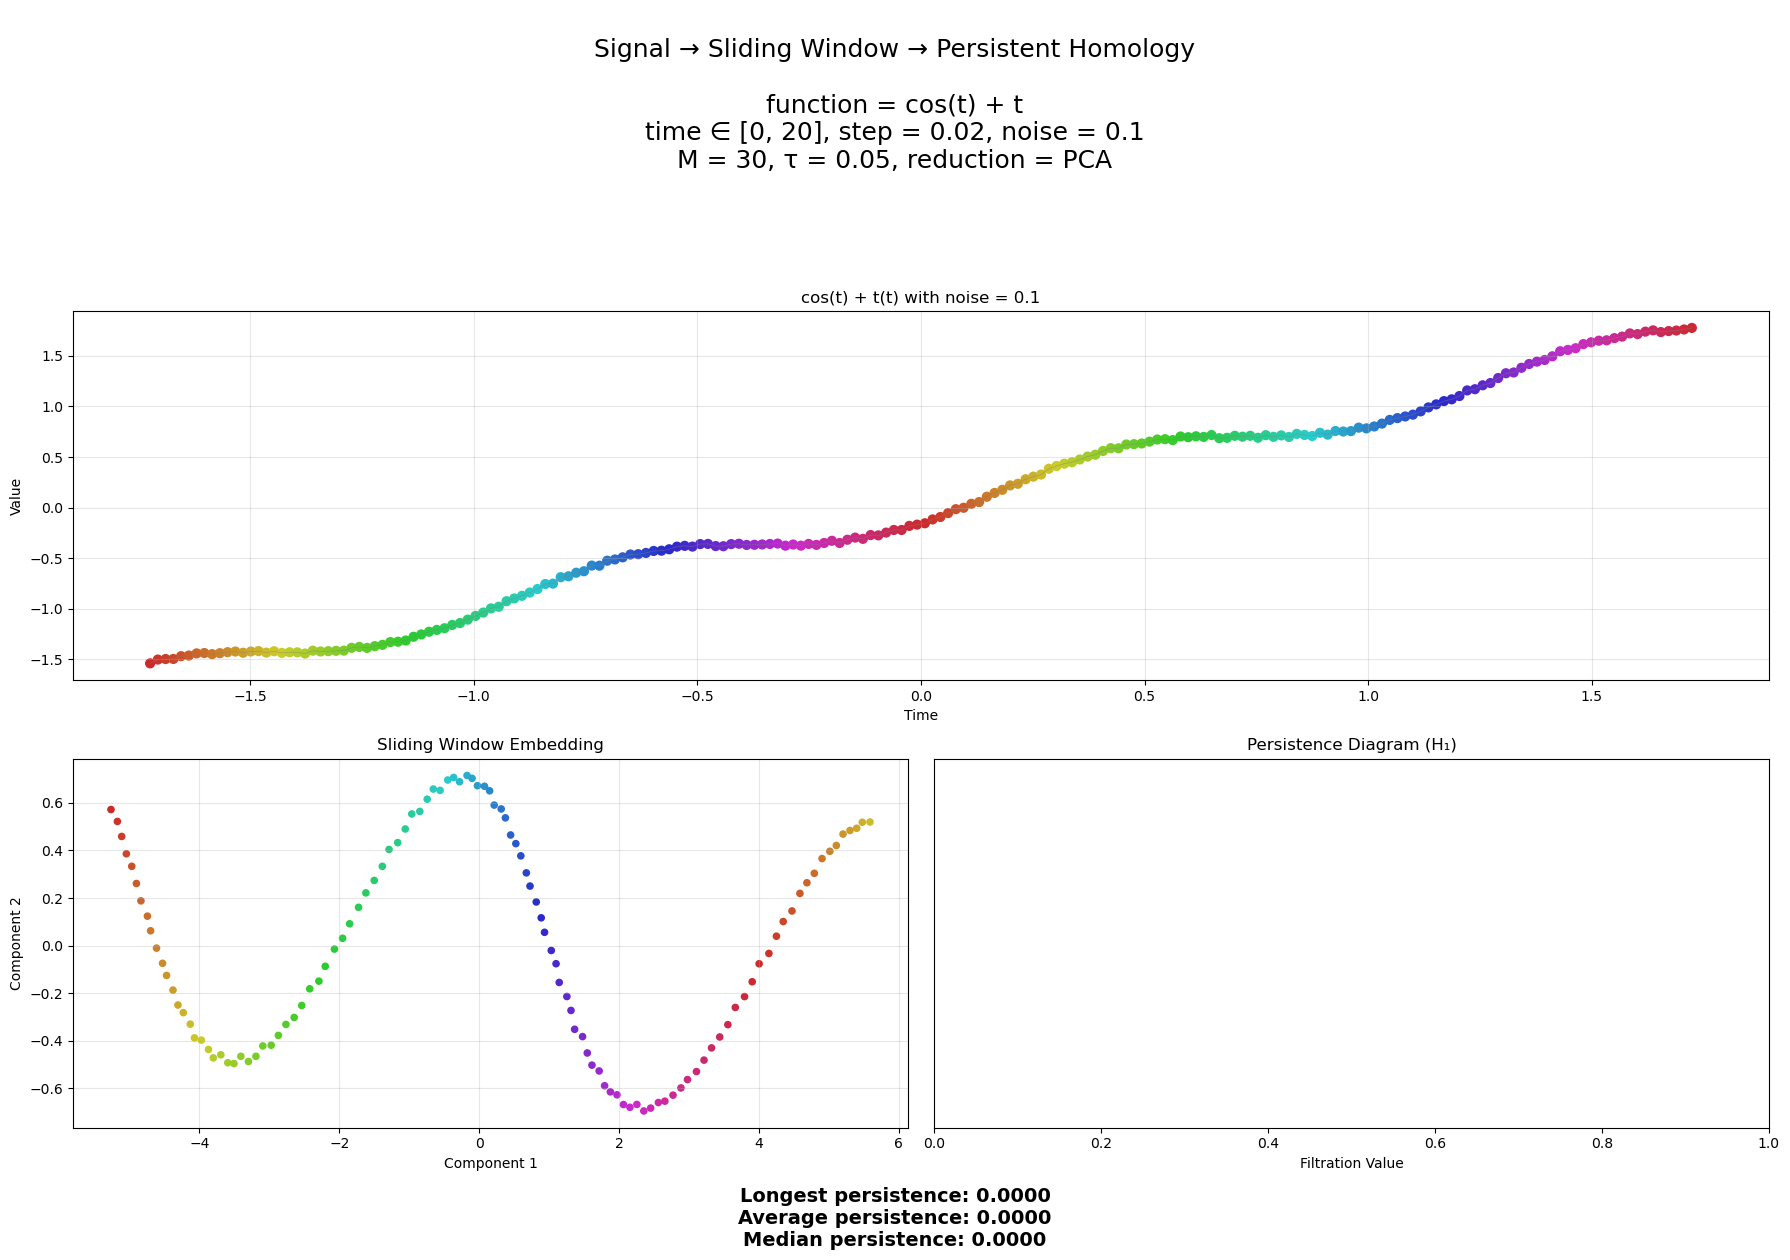

In [24]:
main(
    function_name="cos(t) + t",
    function=lambda x: np.cos(x) + x,
    start_time=0,
    end_time=20,
    step=0.02,
    noise=0.1,
    M=30,
    tau=0.05,
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=200,
)

In [25]:
main(
    function_name="cos(2t) + log(t+1)",
    function=lambda x: np.cos(2 * x) + np.log(x + 1),
    start_time=0,
    end_time=20,
    step=0.02,
    noise=0.1,
    window_size=30,
    tau=0.05,
    reduction_method="pca",
    downscale_signal=True,
    signal_num_points=200,
)

TypeError: main() got an unexpected keyword argument 'window_size'

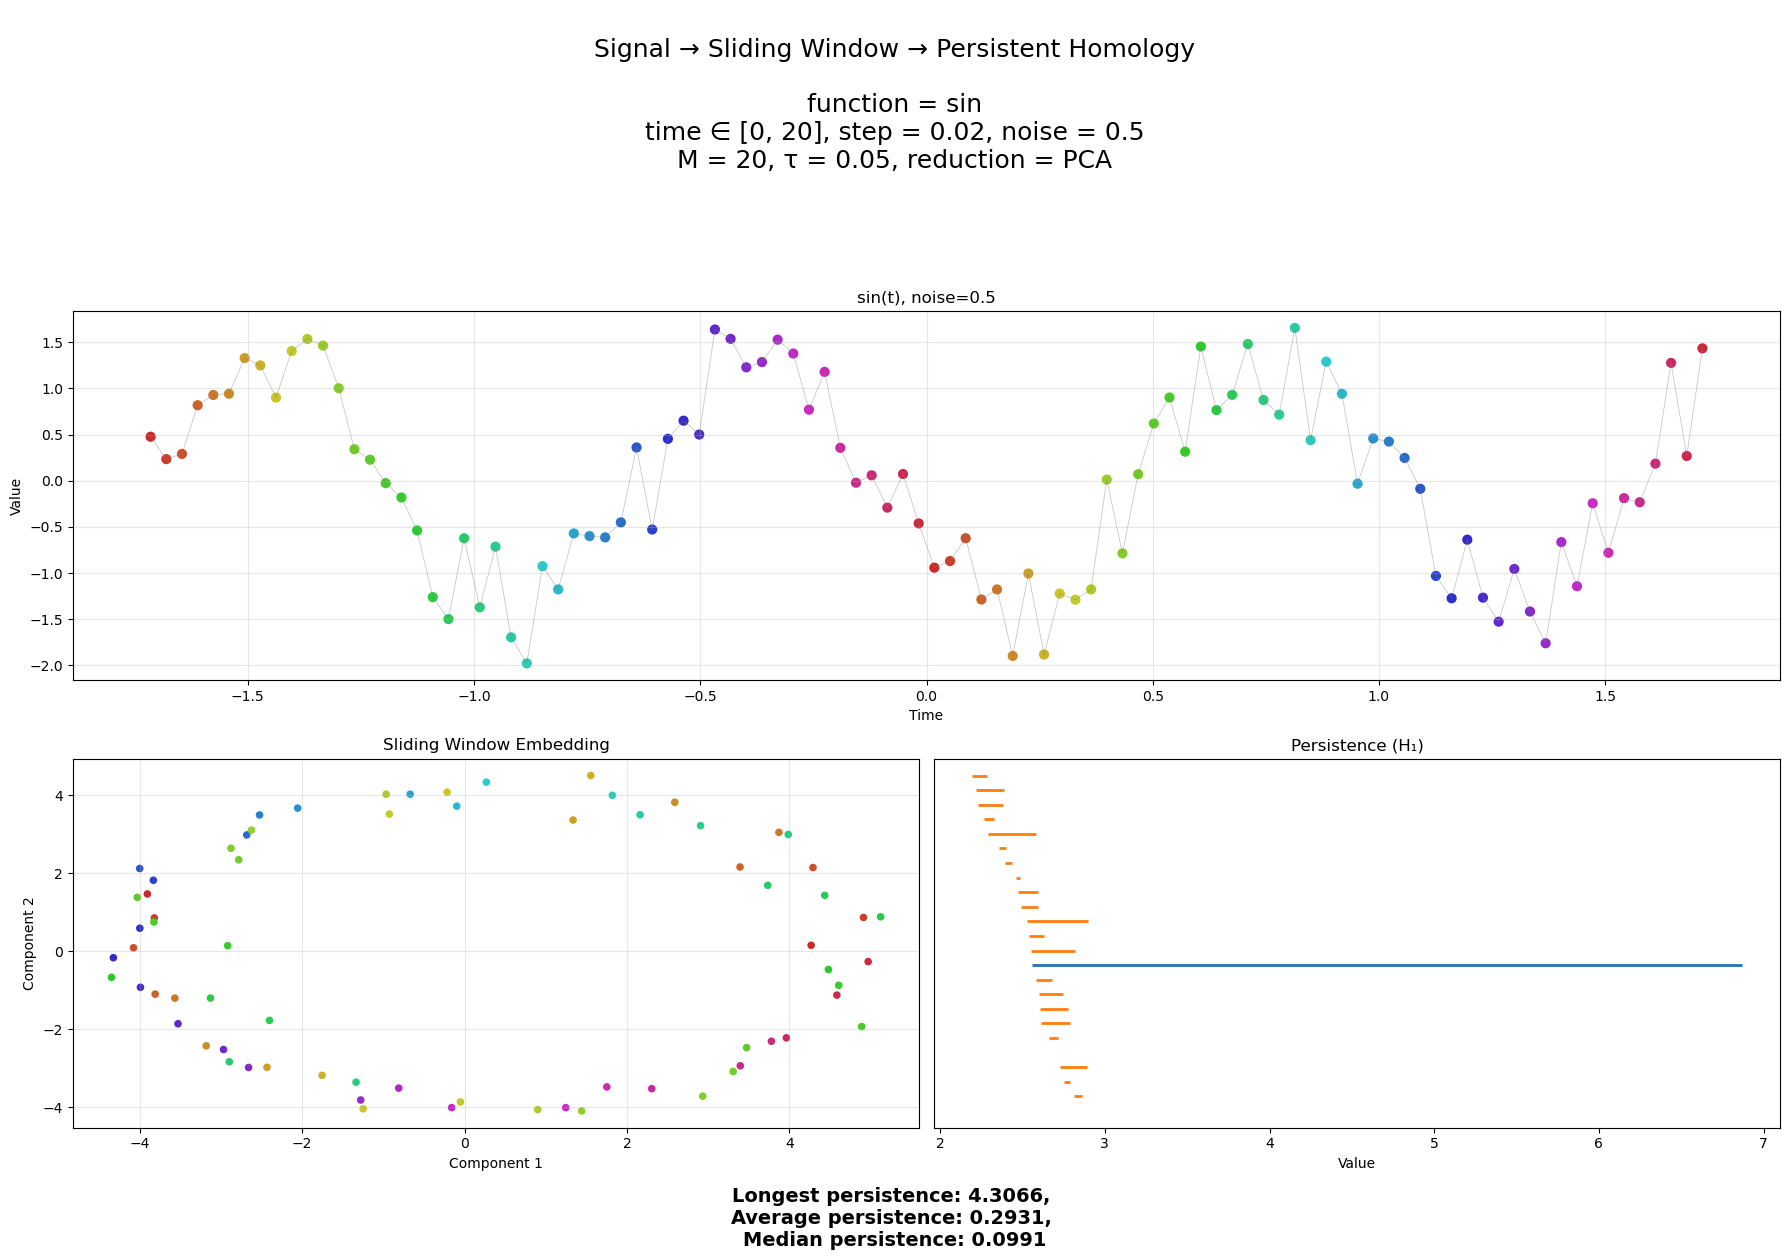

In [ ]:
main(
    function_name="sin",
    function=lambda x: np.sin(x),
    start_time=0,
    end_time=20,
    step=0.02,
    noise=0.5,
    M=20,
    tau=0.05,
    method="pca",
    number_of_points=100
)

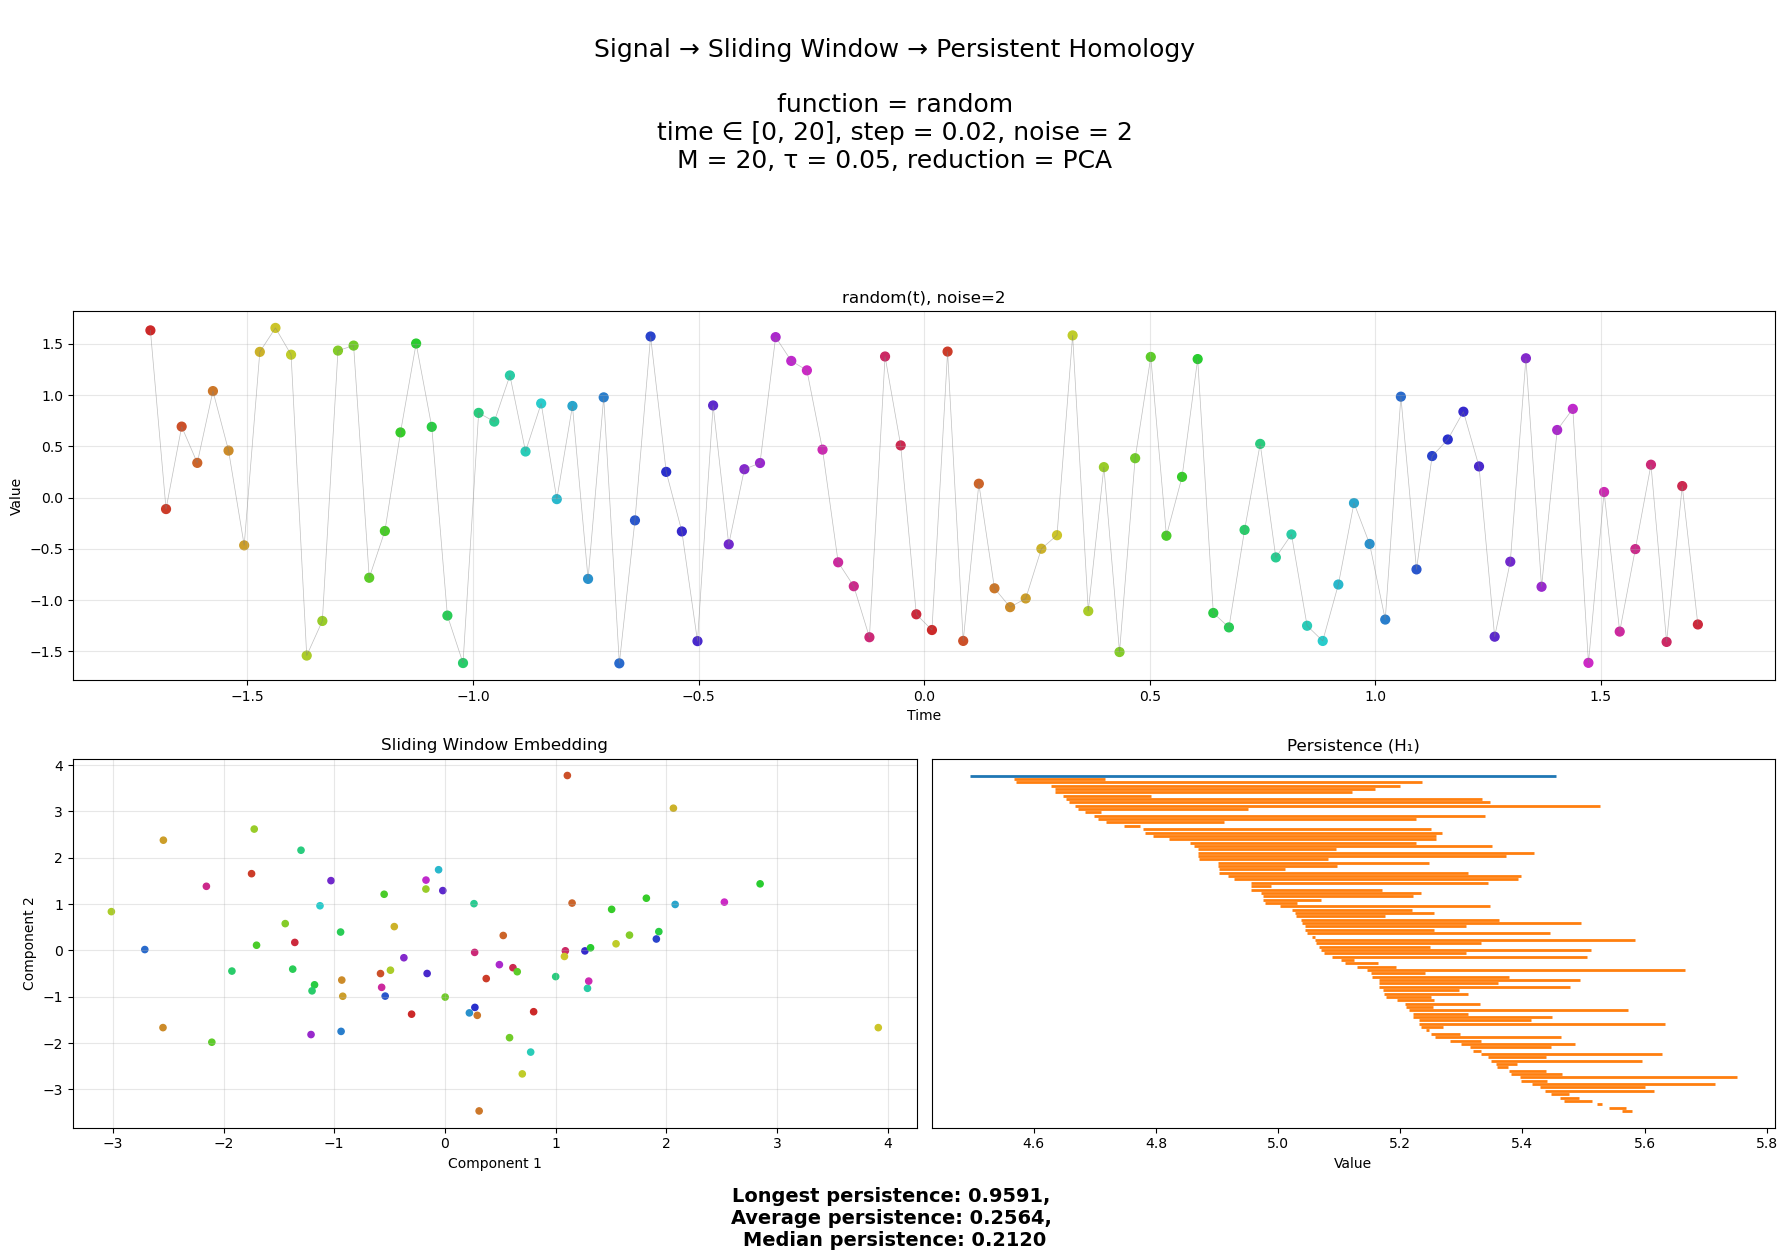

In [ ]:
main(
    function_name="random",
    function=lambda x: 0,
    start_time=0,
    end_time=20,
    step=0.02,
    noise=2,
    M=20,
    tau=0.05,
    method="pca",
    number_of_points=100
)

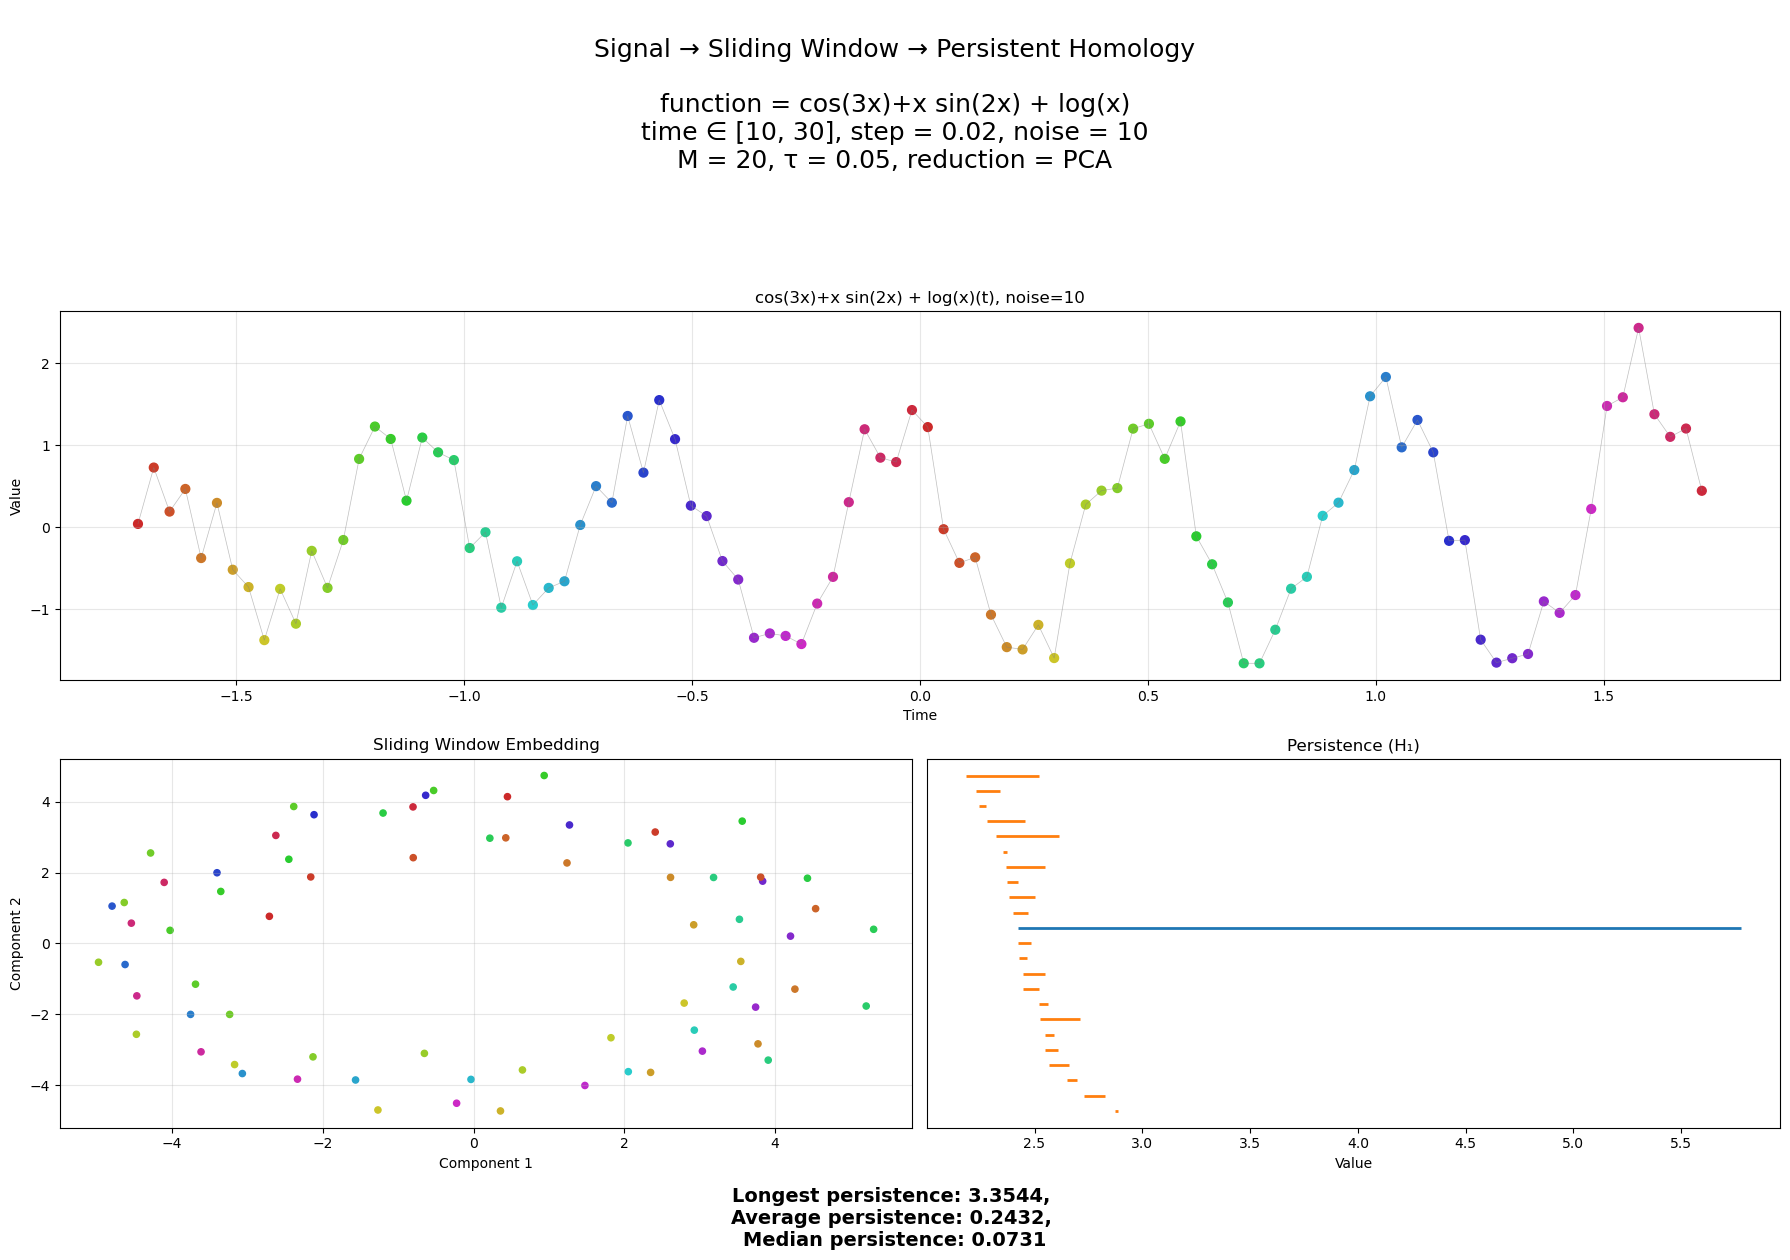

In [ ]:
main(
    function_name="cos(3x)+x sin(2x) + log(x)",
    function=lambda x: np.cos(3*x) + x * np.sin(2*x) + np.log(x),
    start_time=10,
    end_time=30,
    step=0.02,
    noise=10,
    M=20,
    tau=0.05,
    method="pca",
    number_of_points=100
)

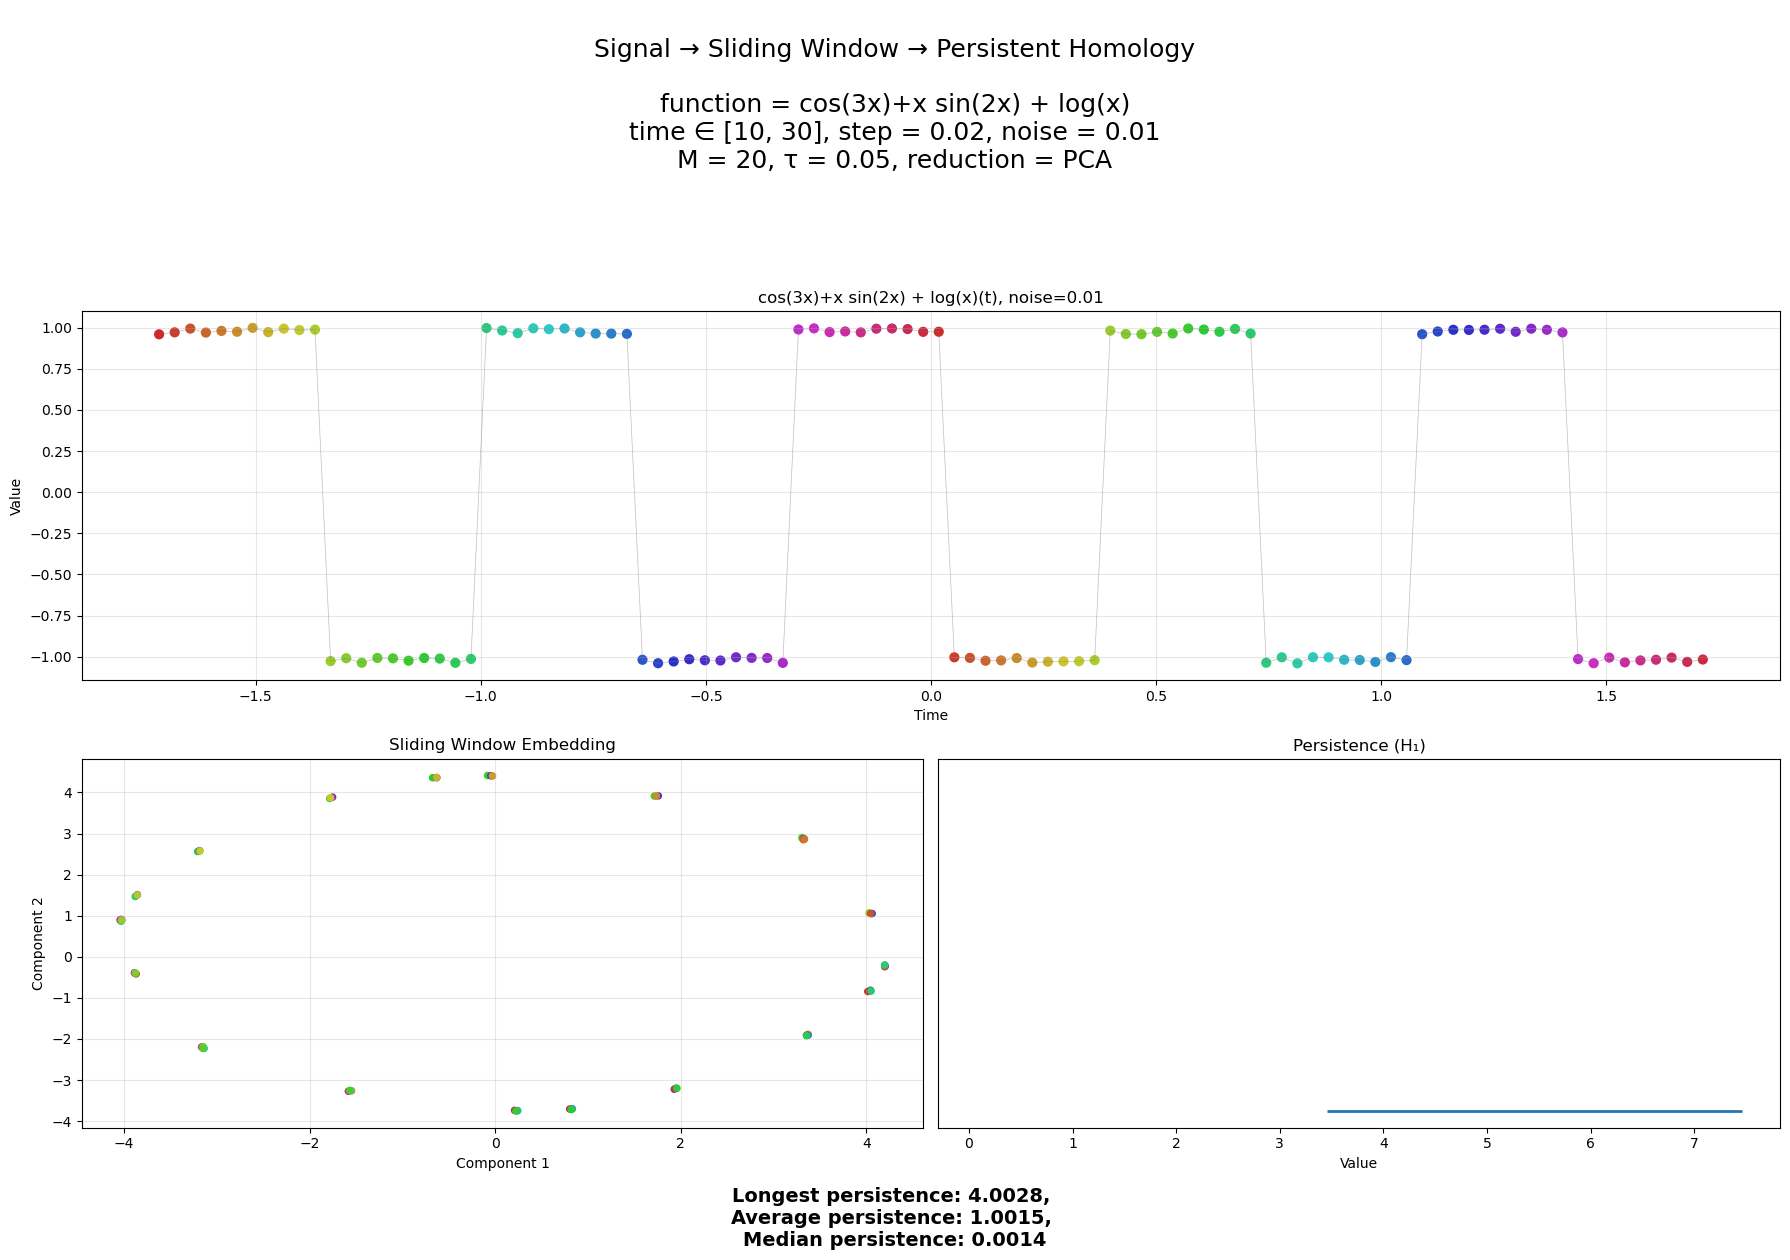

In [ ]:
main(
    function_name="cos(3x)+x sin(2x) + log(x)",
    function=lambda x: 0 if int(x/2)%2 == 0 else 1,
    start_time=10,
    end_time=30,
    step=0.02,
    noise=0.01,
    M=20,
    tau=0.05,
    method="pca",
    number_of_points=100
)